# What are Level Set Trees?

### To-Dos

- Write a clean plot pattern for multiple connected components.
- Keep the color scale constant across the plots.
- Add the colobar to the plots with density coloring.
- Add text to the plots showing the density and mass levels and current point to consider.
- Finish the sub-section about components vanishing.
- Do the section about repsenting the LST with the dendrogram.

*DeBaCl* is a Python package for building and using **Level Set Trees (LSTs)**. As the DeBaCl readme says, these trees are most often used for high-quality clustering, exploratory data analysis, understanding data topology, and detecting anomalies.

This is great, but what exactly *is* an LST? How does the method work? In this notebook I work through each of the steps for constructing an LST. This code is meant for illustration purposes only; for actual uses, the *DeBaCl* package does all of these steps for you.

In [1]:
def plot_points(X, figsize=(8, 6), **kwargs):
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=figsize)
        ax.scatter(X[:, 0], X[:, 1], **kwargs)
        
    return fig

def plot_edges(X, graph, fig):
    ax = fig.gca()
    for v1, v2 in graph.edges():
        ax.plot((X[v1, 0], X[v2, 0]), (X[v1, 1], X[v2, 1]),
                color='black', alpha=0.5, zorder=0)
    
    return fig

## Starting with data

As usual, we start with data: 200 observations generated by the [Scikit-learn two moons function](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). Although the clusters in this dataset are obvious to the naked eye, it is a relatively complicated distribution---one that cannot be well-recovered by parametric clustering methods like K-means.

/home/brian/miniconda/envs/dcl-dev/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/brian/miniconda/envs/dcl-dev/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


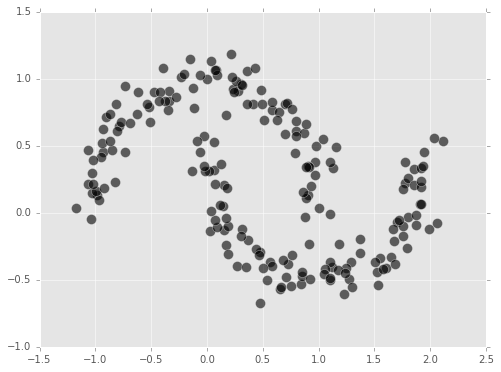

In [2]:
import debacl as dcl
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

n = 200

moons, y = make_moons(n_samples=n, noise=0.1, random_state=19)

fig = plot_points(moons, c='black', s=100, alpha=0.6)
fig.show()

## DeBaCl's output

Here's what you get by running DeBaCl on this dataset. Without pruning any of the small branches, we have 15 clusters in our tree. We can see the statistics about each of these clusters (`start_level`, `end_level`, `start_mass`, `end_mass`, and `size`) either by printing or plotting the tree as a dendrogram.

In [3]:
k = 20  # number of neighbors for estimating connectivity

tree = dcl.construct_tree(moons, k=k)
tree

+----+-------------+-----------+------------+----------+------+--------+----------+
| id | start_level | end_level | start_mass | end_mass | size | parent | children |
+----+-------------+-----------+------------+----------+------+--------+----------+
| 0  |    0.000    |   0.185   |   0.000    |  0.195   | 200  |  None  |  [1, 2]  |
| 1  |    0.185    |   0.298   |   0.195    |  0.700   |  82  |   0    |  [3, 4]  |
| 2  |    0.185    |   0.306   |   0.195    |  0.750   |  79  |   0    |  [5, 6]  |
| 3  |    0.298    |   0.309   |   0.700    |  0.775   |  23  |   1    |  [7, 8]  |
| 4  |    0.298    |   0.331   |   0.700    |  0.895   |  6   |   1    | [11, 12] |
| 5  |    0.306    |   0.343   |   0.750    |  0.905   |  19  |   2    | [13, 14] |
| 6  |    0.306    |   0.394   |   0.750    |  0.995   |  7   |   2    |    []    |
| 7  |    0.309    |   0.316   |   0.775    |  0.825   |  12  |   3    | [9, 10]  |
| 8  |    0.309    |   0.360   |   0.775    |  0.935   |  4   |   3    |    

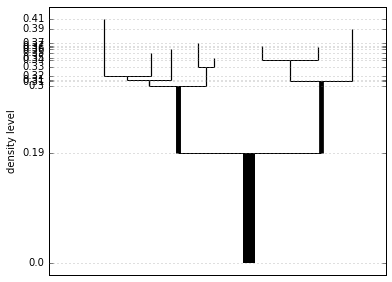

In [4]:
fig = tree.plot(form='density')[0]

## Building a level set tree

Now that we've seen the LST produced by DeBaCl, we'll work through each of the steps that DeBaCl does under the hood.

### 1. Construct a similarity graph

The similarity graph repesents each data point as a vertex, and connects a pair of vertices with an edge if the pair are considered to be neighbors. The definition of neighbors depends on a distance function and a policy for deciding when two points are sufficiently near each other. By default, DeBaCl uses Euclidean distance with a [k-nearest neighbors graph](https://en.wikipedia.org/wiki/Nearest_neighbor_graph), where each point is connected to the `k` points closest to it.

In [5]:
import networkx as nx

adjacency_list, radii = dcl.utils.knn_graph(moons, k=k)

similarity_graph = nx.from_dict_of_lists(
    {i: neighbors for i, neighbors in enumerate(adjacency_list)})

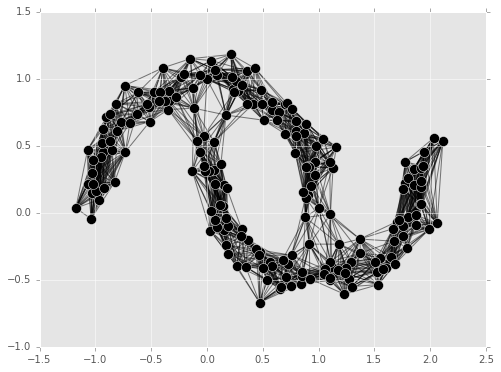

In [6]:
fig = plot_points(moons, c='black', s=100, alpha=1.0)
fig = plot_edges(moons, similarity_graph, fig)
fig.show()

## 2. Estimate the probability density at each point

The probability density function describes how likely it is to draw a point from any spot in our feature space. To build an LST we estimate the density at each of our data points. Points with higher density are located in regions where it is much more likely to draw more data.

By default, DeBaCl uses the k-nearest neighbors density estimate because it requires very little additional computation once we've computed a k-nearest neighbors similarity graph. [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) is another popular method that can be used instead.

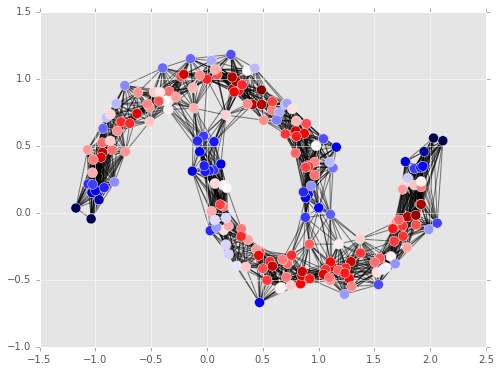

In [7]:
density = dcl.utils.knn_density(radii, n, p=2, k=k)

fig = plot_points(moons, c=density, s=100, alpha=1.0, cmap=plt.cm.seismic)
fig = plot_edges(moons, similarity_graph, fig)
fig.show()

We also need to determine the order of the points from lowest to higher density (no need to sort the data points themselves though).

In [9]:
import numpy as np

filter_order = np.argsort(density)

## 3. Find the connected components in the full graph

At its core, the LST method is simply keeping track of the connected components in our similarity graph. We will start removing vertices and edges from this graph in steps 5-7, but the LST starts with the components with all points included. Usually there is a single connected component in the full similarity graph, but this is not necessary. If there is more than one component, then our LST has multiple "root" nodes.

In [10]:
cc0 = list(nx.connected_component_subgraphs(similarity_graph))
print len(cc0)

1


## 5. Remove the lowest density point and all incident edges 

The first element of the `filter_order` list is the index of the point with the lowest density. We remove this point's vertex from the similarity graph and the 10 edges that touched this point.

In [11]:
similarity_graph.remove_nodes_from([filter_order[0]])

## 6. Compute the connected components in the new graph

Next we compute the connected components in the new, reduced similarity graph. In this case, there is still a single connected component. When this happens, the LST method does nothing. We simply move on to step 7.

In [12]:
cc1 = list(nx.connected_component_subgraphs(similarity_graph))
print len(cc1)

1


## 7. Repeat steps 5 and 6 until all points have been removed.

The core of the LST method is to compute connected components in the similarity graph as we remove points from smallest to largest density. Let's say we are about to remove data point $x$ from the similarity graph. Whatever our similarity graph looks like at this stage, $x$ must belong to a single connected component in the graph, call it $C$. When $x$ and its incident eges are removed, one of three things has to happen:

1. Connected component $C$ remains the same, except that $x$ is gone. In this case, we do nothing (like sections 5 and 6 above), and move on to the next point to be removed.

2. Component $C$ splits into multiple descendent components. Here we record statistics about the "end" of component $C$ and the "start" of $C$'s child components. In particular we say the density level of point $x$ is the "end level" of component $C$ and the "start level" of each of $C$'s child components. The "end mass"/"start_mass" value is the fraction of the data that has been removed at this stage.

3. Component $C$ vanishes, if $x$ was the very last point in $C$. In this case we record the "end level" and "end mass" of component $C$, but there are no child components for which to record the start level and start mass.

Importantly, in cases 1 and 2, the connected components are always *subgraphs* of their parent components. This means that the components form a hierarchy as points are removed, hence name level set *tree*.

### The first split

In this example, we can remove the first 38 points and still maintain our single connected component.

In [13]:
first_split_point = 39

similarity_graph.remove_nodes_from(filter_order[:first_split_point - 1])

cc2 = list(nx.connected_component_subgraphs(similarity_graph))
print "number of components:", len(cc2)

number of components: 1


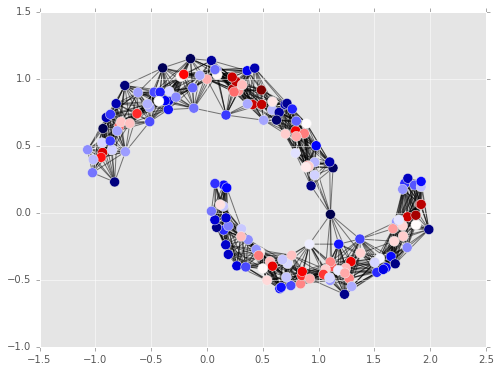

In [16]:
cc_points = cc2[0].nodes()
fig = plot_points(moons[cc_points], c=density[cc_points], s=100, alpha=1.0, cmap=plt.cm.seismic)
fig = plot_edges(moons, cc2[0], fig)
fig.show()

In [17]:
similarity_graph.remove_nodes_from(filter_order[:first_split_point])
cc3 = list(nx.connected_component_subgraphs(similarity_graph))
cc3

- Keep track of the density level where the connected component started
- Keep track of the density level where the CC splits or vanishes
- Keep track of the *mass* levels at each of these points.

## 8. Draw the LST as a dendrogram

## Resources

- PyData talk (Dato GDrive)
    - Figures and code from the talk are on **lenana:~/projects/pydata_talk**
- JSS paper submission
- Dissertation

## Why are we doing all this? The statistical perspective.

As a statistical method, the LST approach assumes a dataset is drawn from an unobservable probability distribution. What we would *like* to be able to do is describe the shape of the probability distribution that generated our data. This is impossible for a couple reasons, but let's work through what we *would* do if we could.

- Show contours of the true PDF (get by sampling a lot of points from `make_moons`.
- Take two upper level sets. For each one, show the region, show the topologically connected components, and observe that they would form a tree.
- Intersect the connected components with the data to get data clusters.